In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

# supress some warnings that mess up my slides
import warnings; warnings.simplefilter('ignore')

In [2]:
student_name = "Pyakorn Munegan (Mona)"
student_id = "46318461"

## Predicting the Genre of Books from Summaries

We'll use a set of book summaries from the [CMU Book Summaries Corpus](http://www.cs.cmu.edu/~dbamman/booksummaries.html) in this experiment.  This contains a large number of summaries (16,559) and includes meta-data about the genre of the books taken from Freebase.  Each book can have more than one genre and there are 227 genres listed in total.  To simplify the problem of genre prediction we will select a small number of target genres that occur frequently in the collection and select the books with these genre labels.  This will give us one genre label per book. 

Your goal in this portfolio is to take this data and build predictive models to classify the books into one of the five target genres.  You will need to extract suitable features from the texts and select suitable models to classify them. You should build and evaluate at least TWO models and compare the prediction results.

You should report on each stage of your experiment as you work with the data.


## Data Preparation

The first task is to read the data. It is made available in tab-separated format but has no column headings. We can use `read_csv` to read this but we need to set the separator to `\t` (tab) and supply the column names.  The names come from the [ReadMe](data/booksummaries/README.txt) file.

In [3]:
names = ['wid', 'fid', 'title', 'author', 'date', 'genres', 'summary']

books = pd.read_csv("data/booksummaries/booksummaries.txt", sep="\t", header=None, names=names, keep_default_na=False)
books.head()

,wid,fid,title,author,date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,,,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [4]:
print(books.shape)

(16559, 7)


We next filter the data so that only our target genre labels are included and we assign each text to just one of the genre labels.  It's possible that one text could be labelled with two of these labels (eg. Science Fiction and Fantasy) but we will just assign one of those here. 

In [5]:
target_genres = ["Children's literature",
                 "Science Fiction",
                 "Novel",
                 "Fantasy",
                 "Mystery"]

# create a Series of empty strings the same length as the list of books
genre = pd.Series(np.repeat("", books.shape[0]))
# look for each target genre and set the corresponding entries in the genre series to the genre label
for g in target_genres:
    genre[books['genres'].str.contains(g)] = g

# add this to the book dataframe and then select only those rows that have a genre label
# drop some useless columns
books['genre'] = genre
genre_books = books[genre!=''].drop(['genres', 'fid', 'wid'], axis=1)

print(genre_books.shape)
print(genre_books.head(5))

(8954, 5)
                  title             author        date  \
0           Animal Farm      George Orwell  1945-08-17   
1    A Clockwork Orange    Anthony Burgess        1962   
2            The Plague       Albert Camus        1947   
4  A Fire Upon the Deep       Vernor Vinge               
6  A Wizard of Earthsea  Ursula K. Le Guin        1968   

                                             summary                  genre  
0   Old Major, the old boar on the Manor Farm, ca...  Children's literature  
1   Alex, a teenager living in near-future Englan...                  Novel  
2   The text of The Plague is divided into five p...                  Novel  
4   The novel posits that space around the Milky ...                Fantasy  
6   Ged is a young boy on Gont, one of the larger...                Fantasy  


In [6]:
# check how many books we have in each genre category
genre_books.groupby('genre').count()

,title,author,date,summary
genre,,,,
Children's literature,1092,1092,1092,1092
Fantasy,2311,2311,2311,2311
Mystery,1396,1396,1396,1396
Novel,2258,2258,2258,2258
Science Fiction,1897,1897,1897,1897


## Feature Exaction

Now you take over to build a suitable model and present your results.

Firstly, you need to perform feature extraction to produce feature vectors for the predictive models.

In [7]:
genre_books.head(5)

,title,author,date,summary,genre
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy


In [8]:
genre_books.summary.head()

0     Old Major, the old boar on the Manor Farm, ca...
1     Alex, a teenager living in near-future Englan...
2     The text of The Plague is divided into five p...
4     The novel posits that space around the Milky ...
6     Ged is a young boy on Gont, one of the larger...
Name: summary, dtype: object

In [9]:
print(genre_books.isnull().sum())

title      0
author     0
date       0
summary    0
genre      0
dtype: int64


In [10]:
len(genre_books.summary) #8954
len(genre_books.genre) #8954

8954

In [11]:
X = genre_books['summary']
y = genre_books['genre']

In [12]:
vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(X)
vectorizer_msg = vectorizer.transform(X)

#create df to contain words
word_matrix = vectorizer_msg.toarray() 
df = pd.DataFrame(word_matrix, columns = vectorizer.get_feature_names()) #create df from matrix
#df.shape

#bag-of-words
dfsum = df.sum(axis=0, skipna=True)
bow = dfsum.sort_values(ascending=False)[:30]
#bow

In [13]:
vectorizer2 = CountVectorizer(stop_words='english')
vectorizer2 = vectorizer2.fit(X)
vectorizer_msg2 = vectorizer2.transform(X)

#create df to contain words
word_matrix2 = vectorizer_msg2.toarray()
df = pd.DataFrame(word_matrix2, columns = vectorizer2.get_feature_names())
#df.shape

#bag-of-words
dfsum2 = df.sum(axis=0, skipna=True)
bow2 = dfsum2.sort_values(ascending=False)[:30]
#bow2

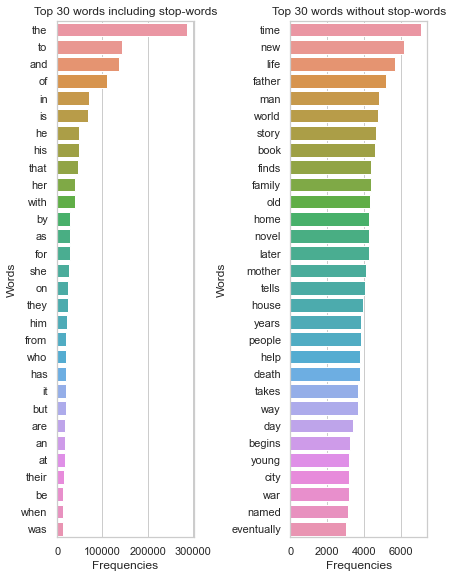

In [14]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(1, 2, figsize = (6, 8))
g1 = sns.barplot(bow.values, bow.index, ax=ax[0]).set(xlabel='Frequencies', ylabel='Words', title = 'Top 30 words including stop-words')
g2 = sns.barplot(bow2.values, bow2.index, ax=ax[1]).set(xlabel='Frequencies', ylabel='Words', title = 'Top 30 words without stop-words')
fig.tight_layout(pad=0.5) #adjust padding between subplots
plt.show()

The graphs above comparing between the top 30 words with and without stop-words. It can be seen that 'the' has the most frequency at almost 300,000 words. However, without stop-words, the most frequency is 'time' at almost 8,000 words.

In [15]:
#Encoding categorical Values
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

labelencoder = preprocessing.LabelEncoder()
#Assigning numerical values and storing in another column
genre_books['genre_cat'] = labelencoder.fit_transform(genre_books['genre'])

le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)
#{"Children's literature":"0", "Fantasy":"1", "Mystery":"2", "Novel":"3", "Science Fiction":"4"}

{"Children's literature": 0, 'Fantasy': 1, 'Mystery': 2, 'Novel': 3, 'Science Fiction': 4}


In [16]:
genre_books.head()

,title,author,date,summary,genre,genre_cat
0,Animal Farm,George Orwell,1945-08-17,"Old Major, the old boar on the Manor Farm, ca...",Children's literature,0
1,A Clockwork Orange,Anthony Burgess,1962,"Alex, a teenager living in near-future Englan...",Novel,3
2,The Plague,Albert Camus,1947,The text of The Plague is divided into five p...,Novel,3
4,A Fire Upon the Deep,Vernor Vinge,,The novel posits that space around the Milky ...,Fantasy,1
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,"Ged is a young boy on Gont, one of the larger...",Fantasy,1


In [17]:
X = genre_books['summary']
y = genre_books['genre_cat']

In [18]:
start = time.time()
tvec = TfidfVectorizer(max_features=20000, stop_words='english')
X_tfidf = tvec.fit_transform(X)
end = time.time()
Time = end - start
print('Time: ', Time)

Time:  3.705181837081909


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=142)

In [20]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (7163, 20000)
y_train shape:  (7163,)
X_test shape:  (1791, 20000)
y_test shape:  (1791,)


## Logistic Regression

### Model Training

In [21]:
start = time.time()
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
end = time.time()
TimeLR = end - start
print('Time: ', TimeLR)

Time:  3.4756836891174316


### Model Evaluation

In [22]:
#Evaluating model on test set
y_pred = logreg.predict(X_test)
accuracyLR = accuracy_score(y_test, y_pred)
f1_LR = f1_score(y_test, y_pred, average="macro")
precision_LR = precision_score(y_test, y_pred, average="macro")
recall_LR = recall_score(y_test, y_pred, average="macro")

print('Accuracy scores:', accuracyLR)

Accuracy scores: 0.6934673366834171


In [23]:
#Evaluating model on train set
y_pred = logreg.predict(X_train)
accuracyLR_train = accuracy_score(y_train, y_pred)

print('Accuracy scores:', accuracyLR_train)

Accuracy scores: 0.8954348736562893


## Multinomial Naive Bayes

### Model Training

In [24]:
start = time.time()
modelNB = MultinomialNB(alpha=0.005)
modelNB.fit(X_train, y_train)
end = time.time()
TimeNB = end - start
print('Time: ', TimeNB)

Time:  0.015985965728759766


### Model Evaluation

In [25]:
#Evaluating model on test set
y_pred = modelNB.predict(X_test)
accuracyNB = accuracy_score(y_test, y_pred)

f1_NB = f1_score(y_test, y_pred, average="macro")
precision_NB = precision_score(y_test, y_pred, average="macro")
recall_NB = recall_score(y_test, y_pred, average="macro")

print('Accuracy scores:', accuracyNB)

Accuracy scores: 0.6795086543830262


In [26]:
#Evaluating model on train set
y_pred = modelNB.predict(X_train)
accuracyNB_train = accuracy_score(y_train, y_pred)

print('Accuracy scores:', accuracyNB_train)

Accuracy scores: 0.9382940108892922


## Gaussian Naive Bayes

### Model Training

In [27]:
start = time.time()
modelGNB = GaussianNB()
modelGNB.fit(X_train.toarray(), y_train)
end = time.time()
TimeGNB = end - start
print('Time: ', TimeGNB)

Time:  5.674436807632446


### Model Evaluation

In [28]:
#Evaluating model on test set
y_pred = modelGNB.predict(X_test.toarray())
accuracyGNB = accuracy_score(y_test, y_pred)
f1_GNB = f1_score(y_test, y_pred, average="macro")
precision_GNB = precision_score(y_test, y_pred, average="macro")
recall_GNB = recall_score(y_test, y_pred, average="macro")

print('Accuracy scores:', accuracyGNB)

Accuracy scores: 0.5097710776102736


In [29]:
#Evaluating model on train set
y_pred = modelGNB.predict(X_train.toarray())
accuracyGNB_train = accuracy_score(y_train, y_pred)

print('Accuracy scores:', accuracyGNB_train)

Accuracy scores: 0.9550467681139188


## Decision Tree

### Model Training

In [30]:
start = time.time()
decisionTree = tree.DecisionTreeClassifier()
decisionTree.fit(X_train, y_train)
end = time.time()
TimeDC = end - start
print('Time: ', TimeDC)

Time:  8.159677982330322


### Model Evaluation

In [31]:
#Evaluating model on test set
y_pred = decisionTree.predict(X_test)
accuracyDC = accuracy_score(y_test, y_pred)
f1_DC = f1_score(y_test, y_pred, average="macro")
precision_DC = precision_score(y_test, y_pred, average="macro")
recall_DC = recall_score(y_test, y_pred, average="macro")

print('Accuracy scores:', accuracyDC)

Accuracy scores: 0.4684533780011167


In [32]:
#Evaluating model on train set
y_pred = decisionTree.predict(X_train)
accuracyDC_train = accuracy_score(y_train, y_pred)

print('Accuracy scores:', accuracyDC_train)

Accuracy scores: 0.9994415747591792


## Random Forest

### Model Training

In [33]:
start = time.time()
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
end = time.time()
TimeRFC = end - start
print('Time: ', TimeRFC)

Time:  17.01892638206482


### Model Evaluation

In [34]:
#Evaluating model on test set
y_pred = rfc.predict(X_test)
accuracyRFC = accuracy_score(y_test, y_pred)
f1_RFC = f1_score(y_test, y_pred, average="macro")
precision_RFC = precision_score(y_test, y_pred, average="macro")
recall_RFC = recall_score(y_test, y_pred, average="macro")

print('Accuracy scores:', accuracyRFC)

Accuracy scores: 0.6443327749860414


In [35]:
#Evaluating model on train set
y_pred = rfc.predict(X_train)
accuracyRFC_train = accuracy_score(y_train, y_pred)

print('Accuracy scores:', accuracyRFC_train)

Accuracy scores: 0.9994415747591792


## Support Vector Classification (SVC)

### Model Training

In [36]:
from sklearn.svm import SVC
start = time.time()
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
end = time.time()
TimeSVC = end - start
print('Time: ', TimeSVC)

Time:  71.67534804344177


### Model Evaluation

In [37]:
#Evaluating model on test set
y_pred = svclassifier.predict(X_test)
accuracySVC = accuracy_score(y_test, y_pred)
f1_SVC = f1_score(y_test, y_pred, average="macro")
precision_SVC = precision_score(y_test, y_pred, average="macro")
recall_SVC = recall_score(y_test, y_pred, average="macro")

print('Accuracy scores:', accuracySVC)

Accuracy scores: 0.7107761027359017


In [38]:
#Evaluating model on train set
y_pred = svclassifier.predict(X_train)
accuracySVC_train= accuracy_score(y_train, y_pred)
print('Accuracy scores:', accuracySVC_train)

Accuracy scores: 0.948904090464889


### Model performance comparison

In [39]:
#Creating new df to store model performances
Model = ['SVC', 'Logistic Regression', 'Multinomial Naive Bayes', 'Gaussian Naive Bayes', 'Decision Trees', 'Random Forest']
Accuracy = [accuracySVC, accuracyLR, accuracyNB, accuracyGNB, accuracyDC, accuracyRFC]  
AC_percent = [accuracySVC*100, accuracyLR*100, accuracyNB*100, accuracyGNB*100, accuracyDC*100, accuracyRFC*100] 
Accuracy_train = [accuracySVC_train, accuracyLR_train, accuracyNB_train, accuracyGNB_train, accuracyDC_train, accuracyRFC_train]
Time = [TimeSVC, TimeLR, TimeNB, TimeGNB, TimeDC, TimeRFC]
F1 = [f1_SVC, f1_LR, f1_NB, f1_GNB, f1_DC, f1_RFC]
Precision = [precision_SVC, precision_LR, precision_NB, precision_GNB, precision_DC, precision_RFC]
Recall = [recall_SVC, recall_LR, recall_NB, recall_GNB, recall_DC, recall_RFC]

#Create df from lists
cols = ['Model', 'Accuracy', 'AC_percent', 'Accuracy_train', 'Time', 'Precision', 'Recall', 'F1']
data = list(zip(Model, Accuracy, AC_percent, Accuracy_train, Time, Precision, Recall, F1))

performance = pd.DataFrame(data, columns=cols)
performance['AC_percent'] = round(performance['Accuracy']*100, 2)
performance

,Model,Accuracy,AC_percent,Accuracy_train,Time,Precision,Recall,F1
0,SVC,0.710776,71.08,0.948904,71.675348,0.720378,0.689966,0.700259
1,Logistic Regression,0.693467,69.35,0.895435,3.475684,0.720838,0.661445,0.674910
2,Multinomial Naive Bayes,0.679509,67.95,0.938294,0.015986,0.693278,0.651351,0.661570
3,Gaussian Naive Bayes,0.509771,50.98,0.955047,5.674437,0.507625,0.475506,0.479994
4,Decision Trees,0.468453,46.85,0.999442,8.159678,0.452439,0.445210,0.447557
5,Random Forest,0.644333,64.43,0.999442,17.018926,0.665922,0.601338,0.607910


### Overfitting?
Look at the extremely high training set accuracy but the lower test set accuracy of each model. It can be assumed that these models are overfitting.

| Model | Test Set Accuracy | Training Set Accuracy | 
| ---: | ---: | ---: |
| SVC | 71.08% | 94.89% |
| Logistic Regression | 69.35% | 89.54% | 
| Multinomial Naive Bayes | 67.95% | 93.83% |
| Random Forest | 63.43% | 99.94% |
| Gaussian Naive Bayes | 50.98% | 95.50% | 
| Decision Tree | 47.29% | 99.94% |


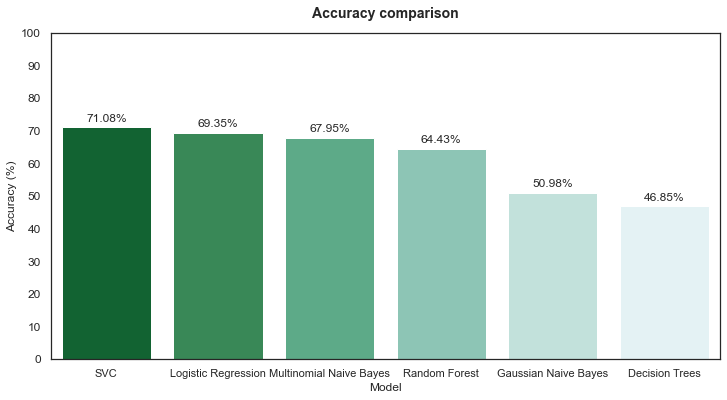

In [40]:
performance.sort_values(by=['AC_percent'], ascending=False, inplace=True)

plt.figure(figsize=(12,6))
sns.set(style='white', font_scale=1)
sns.color_palette("rocket_r", as_cmap=True)

splot = sns.barplot(performance['Model'], performance['AC_percent'], palette="BuGn_r")

plt.xlabel('Model', fontsize = 12)
plt.ylabel('Accuracy (%)', fontsize = 12)
plt.title('Accuracy comparison', fontsize=14, fontweight='bold', pad=15)
plt.yticks(np.arange(0, 110, 10), fontsize= 12)

for p in splot.patches:
    label = "{:.2f}%".format(p.get_height())
    splot.annotate(label, 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 
    
plt.show()

In [41]:
print(performance.loc[:, ['Model','Time']])

                     Model       Time
0                      SVC  71.675348
1      Logistic Regression   3.475684
2  Multinomial Naive Bayes   0.015986
5            Random Forest  17.018926
3     Gaussian Naive Bayes   5.674437
4           Decision Trees   8.159678


### Accuracy Score
If we have a look only the test set accuracy score. The best model is SVC at 71.8%, fllowed by Logistic Regression that is just about 2% less than SVC. Multinomial Naive Bayes is good enough at 67.95%. The rest models'performance of Random Forest, Gaussian Naive Bayes and  Decision Trees are unacceptable espectually the latter two that have the scores under 50%.

### Time efficiency

Time efficiency is another factor that we can use for evaluating the model performance. Among the best accurate models, Multinomial Naive Bayes has the significant fastest processing time at less than a second, followed by Logistic Regression at about 4 seconds and SVC has the worst processing time at 80 seconds.

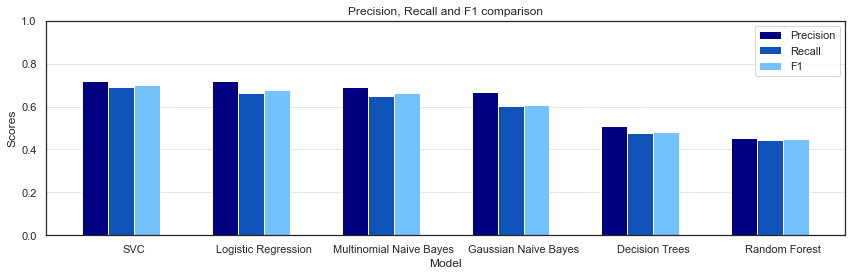

In [42]:
data = np.array(performance.loc[:, ['Precision', 'Recall','F1']])
length = len(data)
x_labels = Model

# Set plot parameters
fig, ax = plt.subplots(figsize = (12, 4))
width = 0.2 # width of bar
x = np.arange(length)

ax.bar(x, data[:,0], width, color='#000080', label='Precision')
ax.bar(x + width, data[:,1], width, color='#0F52BA', label='Recall')
ax.bar(x + (2 * width), data[:,2], width, color='#73C2FB', label='F1')

ax.set_ylabel('Scores')
ax.set_ylim(0,1)
ax.set_xticks(x + width + width/2)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Model')
ax.set_title('Precision, Recall and F1 comparison')
ax.legend()
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.tight_layout()
plt.show()

### Precision, Recall and F1

The Precision, Recall and F1 scores of each model have followed the same trend as the accuracy score.

### Model inference

At this point, I have selected the SVC as it is the best prediction model of this dataset. Let's explore an example of the correct classification of mystery genre compare with an example of a misclassified genre.

In [43]:
test_text = ["""The story involves a series of murders taking place in a wealthy neighborhood of New York. The first murder, of a Mr. Joseph Cochrane Robin who is found pierced by an arrow, is accompanied by a note signed "The Bishop" with an extract from the nursery rhyme Who Killed Cock Robin. This crime takes place at the home of an elderly physicist with a beautiful young ward and a private archery range.""",                             
"""The novel is told in epistolary format, as a series of letters, diary entries, ships' log entries, and so forth. The main writers of these items are also the novel's protagonists. The story is occasionally supplemented with newspaper clippings that relate events not directly witnessed by the story's characters. The tale begins with Jonathan Harker, a newly qualified English solicitor, journeying by train and carriage from England to Count Dracula's crumbling, remote castle (situated in the Carpathian Mountains on the border of Transylvania, Bukovina and Moldavia). The purpose of his mission is to provide legal support to Dracula for a real estate transaction overseen by Harker's employer, Peter Hawkins, of Exeter in England. At first enticed by Dracula's gracious manner, Harker soon discovers that he has become a prisoner in the castle."""]

test_text_vec = tvec.transform(test_text)
y_pred = svclassifier.predict(test_text_vec)
y_pred
print(y_pred)
for i in y_pred:
    print('Genre: ', format(labelencoder.classes_[i]))

[2 3]
Genre:  Mystery
Genre:  Novel


"The story involves a series of murders taking place in a wealthy neighborhood of New York. The first murder, of a Mr. Joseph Cochrane Robin who is found pierced by an arrow, is accompanied by a note signed "The Bishop" with an extract from the nursery rhyme Who Killed Cock Robin. This crime takes place at the home of an elderly physicist with a beautiful young ward and a private archery range."  


In the summary text above, it is obvious that it contains several negative words such as __"murder/murders", "pierced", "Killed",__ and __"crime"__. As a result, the SVC model predicted __mystery__ precisely as an actual genre.


Moving on to the second summary text. 

"The novel is told in epistolary format, as a series of letters, diary entries, ships' log entries, and so forth. The main writers of these items are also the novel's protagonists. The story is occasionally supplemented with newspaper clippings that relate events not directly witnessed by the story's characters. The tale begins with Jonathan Harker, a newly qualified English solicitor, journeying by train and carriage from England to Count Dracula's crumbling, remote castle (situated in the Carpathian Mountains on the border of Transylvania, Bukovina and Moldavia). The purpose of his mission is to provide legal support to Dracula for a real estate transaction overseen by Harker's employer, Peter Hawkins, of Exeter in England. At first enticed by Dracula's gracious manner, Harker soon discovers that he has become a prisoner in the castle."

The actual genre is a mystery but the model predicted novel. It contains a few negative words such as __prisoner__ and __Dracula__(It sound fancier) so that the SVC model predicted this text as a novel instead of a mystery.

### Conlusion

To predict the genre of books based on summaries, first, convert raw data into a data frame that is easier to understand and process. Then, before feeding the predictive models, perform feature extraction to create feature vectors and label encoding to convert the target genres to numeric numbers.

6 predictive models using in this experiment:
- Support Vector Classification (SVC)
- Logistic Regression
- Multinomial Naive Bayes
- Random Forest
- Gaussian Naive Bayes
- Decision Tree

The most accurate models are SVC, Logistic Regression and Multinomial Naive Bayes. While the accuracy of Multinomial Naive Bayes is lower than that of SVC and Logistic Regression, the processing time of Multinomial Naive Bayes is significantly faster than that of other models. For a larger dataset, we must consider model accuracy as well as time efficiency.

Overall, all predictive models' accuracy scores are just about 50 - 70% which is not good enough. To improve the score, we need to perform parameters tuning since the machine learning algorithms are driven by parameters. Other approaches, such as Deep Learning and Doc2vec/word2vec, should also be explored.